# New GraphVAE

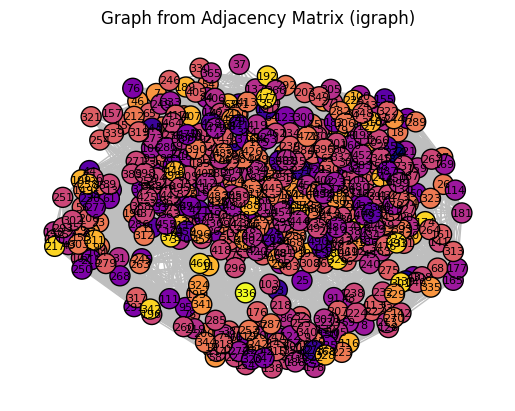

Successfully loaded matrix from data/SMS/wavy2-500/sim_9886/wavy_p_matrix.csv using np.loadtxt().


In [1]:
import numpy as np

from framework.SMS import import_dataset_fromSMS, plot_graph_from_adjacency_matrix

datasetSMS = import_dataset_fromSMS("data/SMS/wavy2-500/")

sim = list(datasetSMS.keys())[0]
mat = datasetSMS[sim]['adjacency_matrix']
num_nodes = mat.shape[0]
p_vectors_array = datasetSMS[sim]['p_array']
dimP = p_vectors_array.shape[1]


plot_graph_from_adjacency_matrix(mat, node_color_scalars=np.sum(p_vectors_array, axis=1), cmap='plasma')

def read_matrix_from_csv_loadtxt(filepath, delimiter=','):
  """
  Reads a NumPy matrix from a CSV file using np.loadtxt().

  Args:
    filepath (str): The path to the CSV file.
    delimiter (str): The character separating values in the CSV file (default is comma).

  Returns:
    numpy.ndarray: The matrix read from the CSV file.
  """
  try:
    matrix = np.loadtxt(filepath, delimiter=delimiter)
    print(f"Successfully loaded matrix from {filepath} using np.loadtxt().")
    return matrix
  except FileNotFoundError:
    print(f"Error: The file '{filepath}' was not found.")
    return None
  except Exception as e:
    print(f"An error occurred while loading the file: {e}")
    return None

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_minmax = MinMaxScaler()
path = "data/SMS/wavy2-500/sim_" + str(sim) + "/wavy_p_matrix.csv"
#p_vectors_array = scaler_minmax.fit_transform(read_matrix_from_csv_loadtxt(path))
p_vectors_array = (read_matrix_from_csv_loadtxt(path))
dimP = p_vectors_array.shape[1]
for x in datasetSMS.values():
    x["p_array"]=p_vectors_array

In [2]:
from framework.trainFct import *
from torch_geometric.data import Data, DataLoader
from framework.visuals import *

latent_dim = 2
input_dim = dimP
batch_size = 16

encoder_hidden_dims=[128, 64, 32]
adj_decoder_hidden_dims=[64, 64, 32]
node_decoder_hidden_dims=[64, 64, 32]
gcn_layers=3
fc_layers=2

dataset = []
for x in datasetSMS.values():
    # Create PyG data object
    data = Data(x=torch.tensor(x["p_array"], dtype=torch.float), 
                edge_index=adj_matrix_to_edge_index(x["adjacency_matrix"])[0], 
                edge_labels=adj_matrix_to_edge_index(x["adjacency_matrix"])[1],
                adjacency_matrix=torch.tensor(x["adjacency_matrix"]))
    dataset.append(data)

# Select a single graph to train on
single_graph = dataset[0]

# Wrap in list for compatibility with DataLoader-like expectations
single_graph_list = [single_graph]


/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

In [ ]:
import torch.nn as nn
from typing import Dict, List, Optional, Tuple, Any, Callable
from abc import ABC, abstractmethod

import gc

from framework.encoder import Encoder
from framework.decoder import DecoderBase
from framework.GraphVAE import KLAnnealingScheduler

from framework.torchVersions.boundedManifold import BoundedManifold


class VAE(nn.Module):
    """
    Flexible VAE model supporting multiple decoders and pluggable priors
    """
    def __init__(
        self,
        encoder: "Encoder",
        decoders: List["DecoderBase"],
        prior: Optional["Prior"] = None,
        kl_scheduler: Optional["KLAnnealingScheduler"] = None,
        freeze_encoder: bool = False,
        compute_latent_manifold: bool = True
    ):
        """
        Args:
            encoder: Encoder modules
            decoders: List of decoder modules
            prior: Prior distribution (defaults to GaussianPrior)
            kl_scheduler: Optional KL annealing scheduler
            freeze_encoder: Whether to freeze the encoder parameters
        """
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoders = nn.ModuleList(decoders)
        self.decoder_dict = {decoder.name: decoder for decoder in decoders}
        self.prior = prior if prior is not None else GaussianPrior()
        self.prior.giveVAEInstance(self)  
        self.kl_scheduler = kl_scheduler if kl_scheduler else KLAnnealingScheduler()

        self.latent_manifold = None
        self.compute_latent_manifold = compute_latent_manifold
        
        # Set encoder freeze state
        self.set_encoder_freeze(freeze_encoder)
        
    def set_encoder_freeze(self, freeze: bool = True):
        """
        Freeze or unfreeze encoder parameters
        
        Args:
            freeze: Whether to freeze encoder parameters
        """
        for param in self.encoder.parameters():
            param.requires_grad = not freeze
            
    def encode(self, x: torch.Tensor, **kwargs) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode graph into latent space
        
        Args:
            x: Node features [num_nodes, input_dim]
            
        Returns:
            mu: Mean of latent distribution
            params: Distribution parameters (e.g., logvar for Gaussian)
        """
        encoder_kwargs = {k: v for k, v in kwargs.items() 
                            if k in self.encoder.forward.__code__.co_varnames}
        return self.encoder(x, **encoder_kwargs)
    
    def reparameterize(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from latent distribution
        
        Args:
            mu: Mean of latent distribution
            params: Distribution parameters
            
        Returns:
            Sampled latent variables
        """
        return self.prior.sample(mu, params)
    
    def decode(self, z: torch.Tensor, **kwargs) -> Dict[str, Dict[str, torch.Tensor]]:
        """
        Decode latent variables through all active decoders
        
        Args:
            z: Latent variables [num_nodes, latent_dim]
            **kwargs: Additional decoder-specific arguments
            
        Returns:
            Dict of outputs from each decoder
        """
        all_outputs = {}
        
        for decoder in self.decoders:
            decoder_kwargs = {k: v for k, v in kwargs.items() 
                              if k in decoder.forward.__code__.co_varnames}
            outputs = decoder(z, **decoder_kwargs)
            all_outputs[decoder.name] = outputs
        
        return all_outputs
    
    def forward(self, x: torch.Tensor, **kwargs) -> Dict[str, Any]:
        """
        Full forward pass
        
        Args:
            x: Node features [num_nodes, input_dim]
            **kwargs: Additional encoder/decoder arguments
            
        Returns:
            Dict with outputs and latent variables
        """
        # Encode
        encoder_kwargs = {k: v for k, v in kwargs.items() 
                            if k in self.encoder.forward.__code__.co_varnames}
        mu, params = self.encode(x, **encoder_kwargs)

        if self.compute_latent_manifold:
            if self.get_latent_manifold() is None:
                manifold_bounds = torch.tensor([[-100, 100]], dtype=torch.float32)
                manifold_bounds = manifold_bounds.repeat(mu.shape[1], 1)
            else:
                manifold_bounds = BoundedManifold.hypercube_bounds(mu, margin=0.2, relative=True)
            self.construct_latent_manifold(manifold_bounds, self.training)
        # Sample latent variables
        z = self.reparameterize(mu, params)
        
        # Decode
        decoder_kwargs = {**kwargs}
        outputs = self.decode(z, **decoder_kwargs)
        
        return {
            "mu": mu,
            "params": params,
            "z": z,
            "outputs": outputs
        }
    
    def compute_loss(
        self, 
        outputs: Dict[str, Any], 
        targets: Dict[str, Dict[str, torch.Tensor]],
        decoder_weights: Optional[Dict[str, float]] = None,
        active_decoders: Optional[List[str]] = None,
        use_custom_losses: bool = True
    ) -> Dict[str, torch.Tensor]:
        """
        Compute total loss from VAE components
        
        Args:
            outputs: Outputs from forward pass
            targets: Target values for each decoder
            decoder_weights: Optional weights for each decoder loss
            active_decoders: Optional list of decoder names to include in loss computation
            use_custom_losses: Whether to include custom decoder losses
            
        Returns:
            Dict with total loss and component losses
        """
        # Default weights if not provided
        if decoder_weights is None:
            decoder_weights = {decoder.name: 1.0 for decoder in self.decoders}
        
        # Use all decoders if active_decoders not specified
        if active_decoders is None:
            active_decoders = list(self.decoder_dict.keys())
        
        # KL divergence loss using pluggable prior
        mu, params = outputs["mu"], outputs["params"]
        kl_loss = self.prior.kl_divergence(mu, params)
        
        # Get current KL weight from scheduler
        kl_weight = self.kl_scheduler.get_weight()
        
        # Compute individual decoder losses
        decoder_losses = {}
        detailed_losses = {}
        weighted_recon_loss = 0
        
        z = outputs["z"]  # Get latent variables for custom losses
        
        for decoder in self.decoders:
            name = decoder.name
            if name not in outputs["outputs"] or name not in active_decoders:
                continue
                
            # Get decoder outputs and corresponding targets
            decoder_outputs = outputs["outputs"][name]
            decoder_targets = targets.get(name, {})
            
            # Compute loss for this decoder (including custom losses if enabled)
            if use_custom_losses and hasattr(decoder, 'compute_total_loss'):
                loss_breakdown = decoder.compute_total_loss(
                    decoder_outputs, decoder_targets, z=z
                )
                decoder_loss = loss_breakdown['total']
                detailed_losses[name] = loss_breakdown
            else:
                decoder_loss = decoder.compute_loss(decoder_outputs, decoder_targets)
                if decoder_loss.ndim > 0:
                    decoder_loss = decoder_loss.sum() 
                detailed_losses[name] = {'base_loss': decoder_loss, 'total': decoder_loss}
            
            if decoder_loss.ndim > 0:
                decoder_loss = decoder_loss.sum() 
            decoder_losses[name] = decoder_loss
            
            # Add weighted loss to total reconstruction loss
            decoder_weight = decoder_weights.get(name, 1.0)
            weighted_recon_loss += decoder_weight * decoder_loss
        
        # Compute total loss
        total_loss = weighted_recon_loss + kl_weight * kl_loss
        
        return {
            "total_loss": total_loss,
            "kl_loss": kl_loss,
            "kl_weight": kl_weight,
            "recon_loss": weighted_recon_loss,
            "decoder_losses": decoder_losses,
            "detailed_losses": detailed_losses
        }
    
    def add_decoder(self, decoder: "DecoderBase"):
        """
        Add a new decoder to the model
        
        Args:
            decoder: Decoder module to add
        """
        self.decoders.append(decoder)
        self.decoder_dict[decoder.name] = decoder
    
    def remove_decoder(self, name: str) -> bool:
        """
        Remove a decoder by name
        
        Args:
            name: Name of the decoder to remove
            
        Returns:
            True if decoder was removed, False if not found
        """
        if name in self.decoder_dict:
            decoder = self.decoder_dict[name]
            self.decoders = nn.ModuleList([d for d in self.decoders if d.name != name])
            self.decoder_dict.pop(name)
            return True
        return False
    
    def get_decoder(self, name: str) -> Optional["DecoderBase"]:
        """
        Get decoder by name
        
        Args:
            name: Name of the decoder
            
        Returns:
            Decoder module or None if not found
        """
        return self.decoder_dict.get(name)
    
    def get_active_decoders(self) -> List[str]:
        """
        Get names of all active decoders
        
        Returns:
            List of decoder names
        """
        return list(self.decoder_dict.keys())
    
    def compute_jacobian(self, z: torch.Tensor, decoder_name: str, node_idx: Optional[int] = None) -> torch.Tensor:
        """
        Compute Jacobian of a specific decoder with respect to latent space
        
        Args:
            z: Latent variables [num_nodes, latent_dim]
            decoder_name: Name of the decoder to compute Jacobian for
            node_idx: Optional node index to compute Jacobian for
            
        Returns:
            Jacobian matrix
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is None:
            raise ValueError(f"Decoder '{decoder_name}' not found")
            
        if hasattr(decoder, "compute_jacobian"):
            return decoder.compute_jacobian(z, node_idx)
        else:
            raise NotImplementedError(f"Decoder '{decoder_name}' does not implement compute_jacobian method")
    
    # Convenience methods for managing custom losses
    def add_custom_loss_to_decoder(self, decoder_name: str, loss_name: str, 
                                  loss_fn: Callable, weight: float = 1.0):
        """
        Add a custom loss to a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name for the custom loss
            loss_fn: Loss function
            weight: Weight for the loss
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is None:
            raise ValueError(f"Decoder '{decoder_name}' not found")
        decoder.add_custom_loss(loss_name, loss_fn, weight)
    
    def remove_custom_loss_from_decoder(self, decoder_name: str, loss_name: str):
        """
        Remove a custom loss from a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss to remove
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.remove_custom_loss(loss_name)
    
    def set_custom_loss_active(self, decoder_name: str, loss_name: str, active: bool = True):
        """
        Activate/deactivate a custom loss for a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss
            active: Whether the loss should be active
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.set_custom_loss_active(loss_name, active)
    
    def set_custom_loss_weight(self, decoder_name: str, loss_name: str, weight: float):
        """
        Update the weight of a custom loss for a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss
            weight: New weight value
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.set_custom_loss_weight(loss_name, weight)

    def _local_decoder_point_metric(self, z, decoder_name: Optional[str] = None) -> torch.Tensor:
        """
        Wrapper to compute the Riemannian metric from the jacobian matrix of decoder_name
        z: numpy array with shape (n,)
        
        Returns an (n x n) metric tensor.
        """
        G = None
        try:
            # Ensure z is a 2D tensor for Jacobian computation (batch_size, n)
            # and specify the output index for the Jacobian
            J = self.compute_jacobian(z, decoder_name)
            G = torch.matmul(J.T, J)

        except Exception as e:
            print(f"Error at grid point ({z.numpy()}): {e}") # Convert z to numpy for printing if needed
        
        # If G is still None due to an error, you might want to raise the exception
        # or return None, depending on desired error handling.
        if G is None:
            raise RuntimeError("Riemannian metric computation failed.")
            
        return G
    
    def construct_latent_manifold(self, bounds: torch.Tensor, force : bool = False, cache : bool = True, 
                                  decoder_name: Optional[str] = None) -> BoundedManifold:
        """
        Construct the latent manifold representation

        Args:
            bounds: bounds of the bounded manifold
            force: if True, we construct a new latent manifold in place of the previous one
            decoder_name: Optional name of the decoder to construct the manifold from

        Returns:
            BoundedManifold object 
        """
        if self.latent_manifold is None or force:
            if decoder_name is None:
                decoder_name = list(self.decoder_dict.keys())[0]
            def local_point_metric(z: torch.Tensor) -> torch.Tensor:
                """Local point metric function for the manifold"""
                return self._local_decoder_point_metric(z, decoder_name)
            
            if self.latent_manifold is not None:
                del self.latent_manifold
                gc.collect()
            self.latent_manifold = BoundedManifold(local_point_metric, bounds=bounds, cache=cache, 
                                                   grid_points_per_dim=100, device=next(self.parameters()).device)
        return self.latent_manifold

    def get_latent_manifold(self):
        """
        Get the latent manifold representation if available

        Returns:
            BoundedManifold object or None if not initialized
        """
        return self.latent_manifold
    
    def set_compute_latent_manifold(self, compute: bool = True):
        """
        Set whether to compute the latent manifold during forward pass

        Args:
            compute: If True, compute the latent manifold
        """
        self.compute_latent_manifold = compute


class Prior(ABC):
    """Abstract base class for priors"""

    def giveVAEInstance(self, model: VAE):
        self.model = model
    
    @abstractmethod
    def sample(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """Sample from the prior distribution"""
        pass
    
    @abstractmethod
    def kl_divergence(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """Compute KL divergence with respect to the prior"""
        pass
    
    @abstractmethod
    def get_param_size(self) -> int:
        """Return the number of parameters needed (e.g., 1 for logvar, 2 for concentration)"""
        pass

class GaussianPrior(Prior):
    """Gaussian prior N(0, I)"""
    
    def sample(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        if mu.device != logvar.device:
            logvar = logvar.to(mu.device)
        
        if mu.requires_grad:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
    
    def kl_divergence(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        return -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    
    def get_param_size(self) -> int:
        return 1  # logvar




In [4]:
class GraphVAE(VAE):

    """
    Graph Variational Autoencoder (GraphVAE) extending the base VAE class
    for graph-structured data.
    
    Inherits from VAE and can be customized with graph-specific encoders and decoders.
    """
    
    def __init__(self, encoder: "Encoder", decoders: List["DecoderBase"], 
                 kl_scheduler: Optional["KLAnnealingScheduler"] = None,
                 freeze_encoder: bool = False,
                 prior: Optional["Prior"] = None,
                 compute_latent_manifold: bool = True):
        super(GraphVAE, self).__init__(encoder, decoders, kl_scheduler=kl_scheduler, freeze_encoder=freeze_encoder, prior=prior, compute_latent_manifold=compute_latent_manifold)


In [5]:
dropout = 0
phase1_epochs = 2
phase2_epochs = 2
lr_phase1 = 0.001
lr_phase2 = 0.05
latent_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1: Create encoder and node decoder for phase 1
encoder = Encoder(
    input_dim=input_dim,
    hidden_dims=[6168, 4112, 2056, 1028, 128],
    latent_dim=latent_dim,
    gcn_layers=4,
    fc_layers=2,
    dropout=dropout,
    activation=nn.ELU()
)
# encoder = MLPEncoder(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     hidden_dims=[5000, 1280,640, 320],
#     mlp_layers=3,
#     dropout=dropout
# )

node_decoder = NodeAttributeDecoder(
    latent_dim=latent_dim,
    output_dim=input_dim,
    hidden_dims=[5000, 128],
    #hidden_dims=[128],
    dropout=dropout,
    activation=nn.ELU(),
    #final_activation=SigmoidBinary(threshold=0.5, temperature=0.1)
)

# Create KL annealing scheduler
kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=0.001,
    anneal_steps=phase1_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Create initial model with only node decoder
model_phase1 = GraphVAE(
    encoder=encoder,
    decoders=[node_decoder],
    kl_scheduler=kl_scheduler,
    compute_latent_manifold=False,
)


In [6]:
print("=== Starting Phase 1: Training encoder with node feature reconstruction ===")

# Phase 1 training
history_phase1 = train_phase1(
    model=model_phase1,
    data_loader=single_graph_list,
    num_epochs=phase1_epochs,
    lr=lr_phase1,
    weight_decay=1e-5,
    verbose=False,
    device=device,
    loss_coefficient=1
)

print("\n=== Phase 1 Complete ===")

=== Starting Phase 1: Training encoder with node feature reconstruction ===
Forward pass: compute_latent_manifold = False self.training = True
Forward pass: compute_latent_manifold = False self.training = True

=== Phase 1 Complete ===


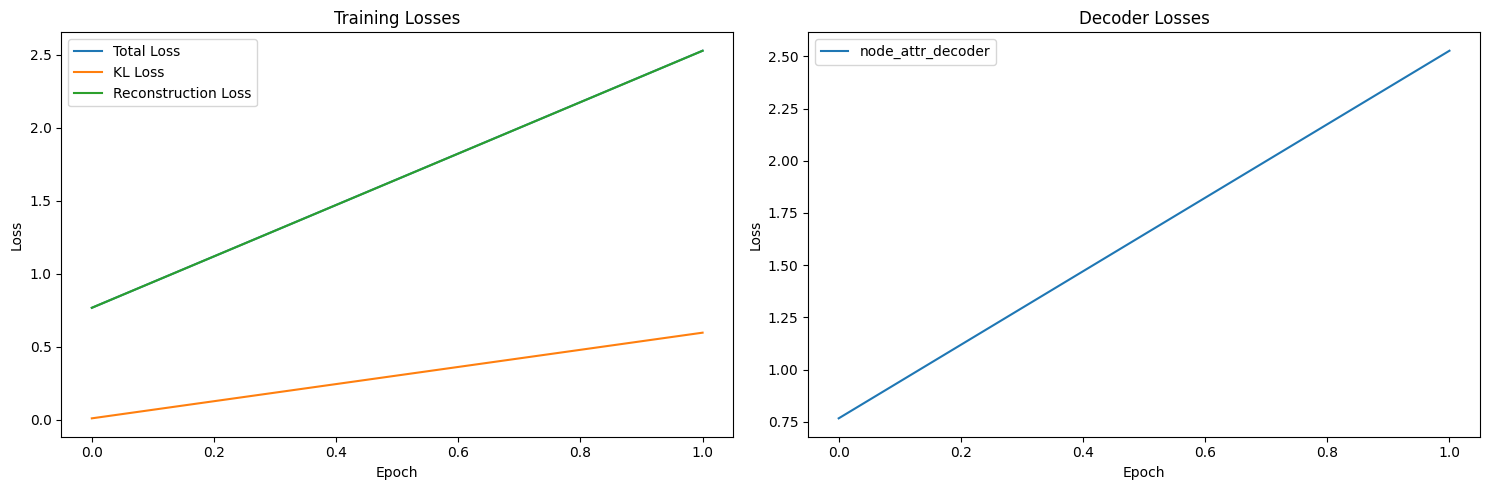

Forward pass: compute_latent_manifold = False self.training = False


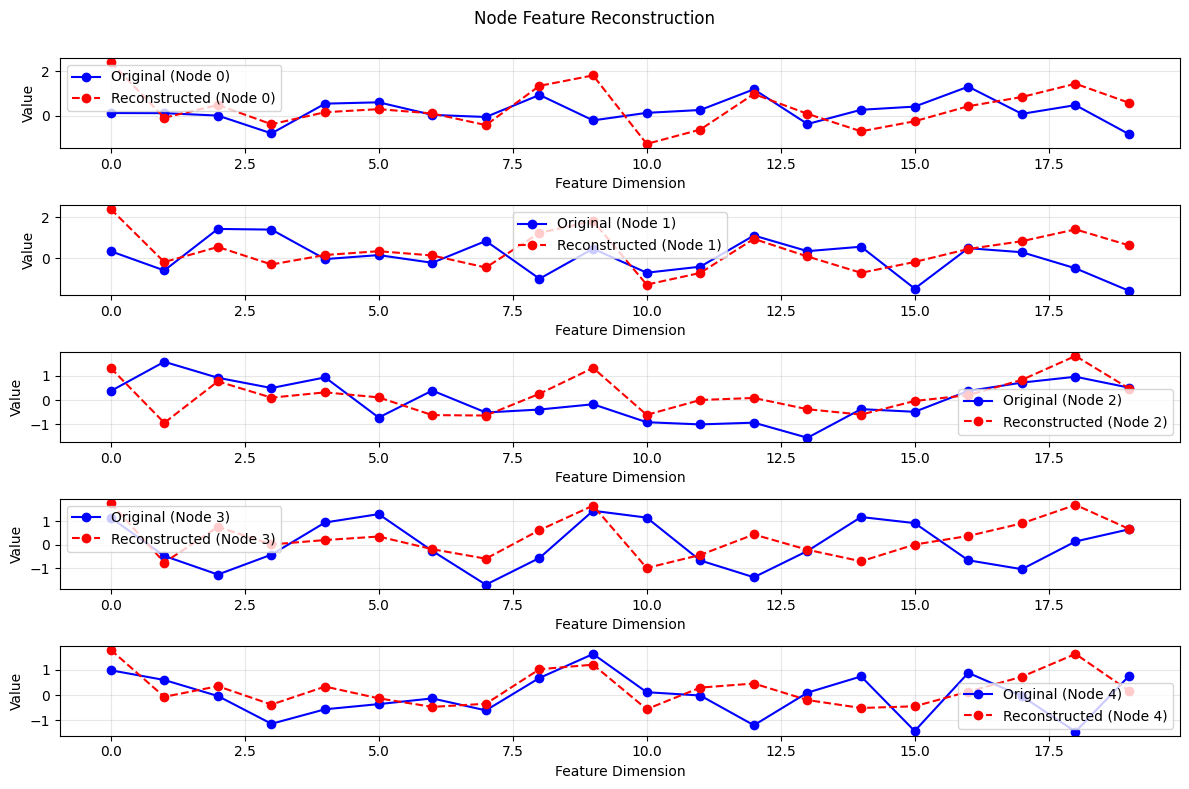

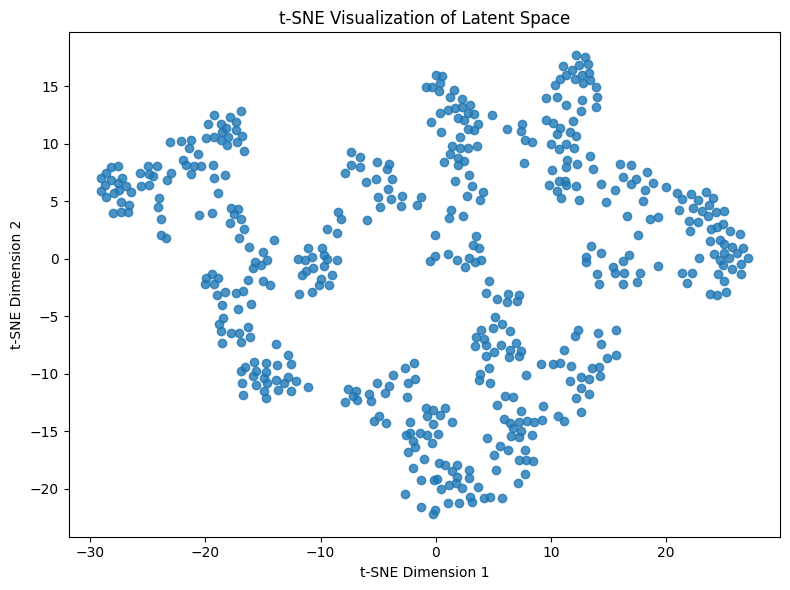

In [7]:
visualize_training(history_phase1)
#visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase1, single_graph, sample_features=dimP)
visualize_latent_space(model_phase1, [single_graph])

In [8]:
# model_phase1.construct_latent_manifold(
#     bounds=torch.tensor([[-5, 5]], dtype=torch.float32).repeat(latent_dim, 1),
#     force=True,
#     decoder_name="node_attr_decoder"
# )

Computing metric tensors: 100%|██████████| 10000/10000 [00:05<00:00, 1957.75it/s]


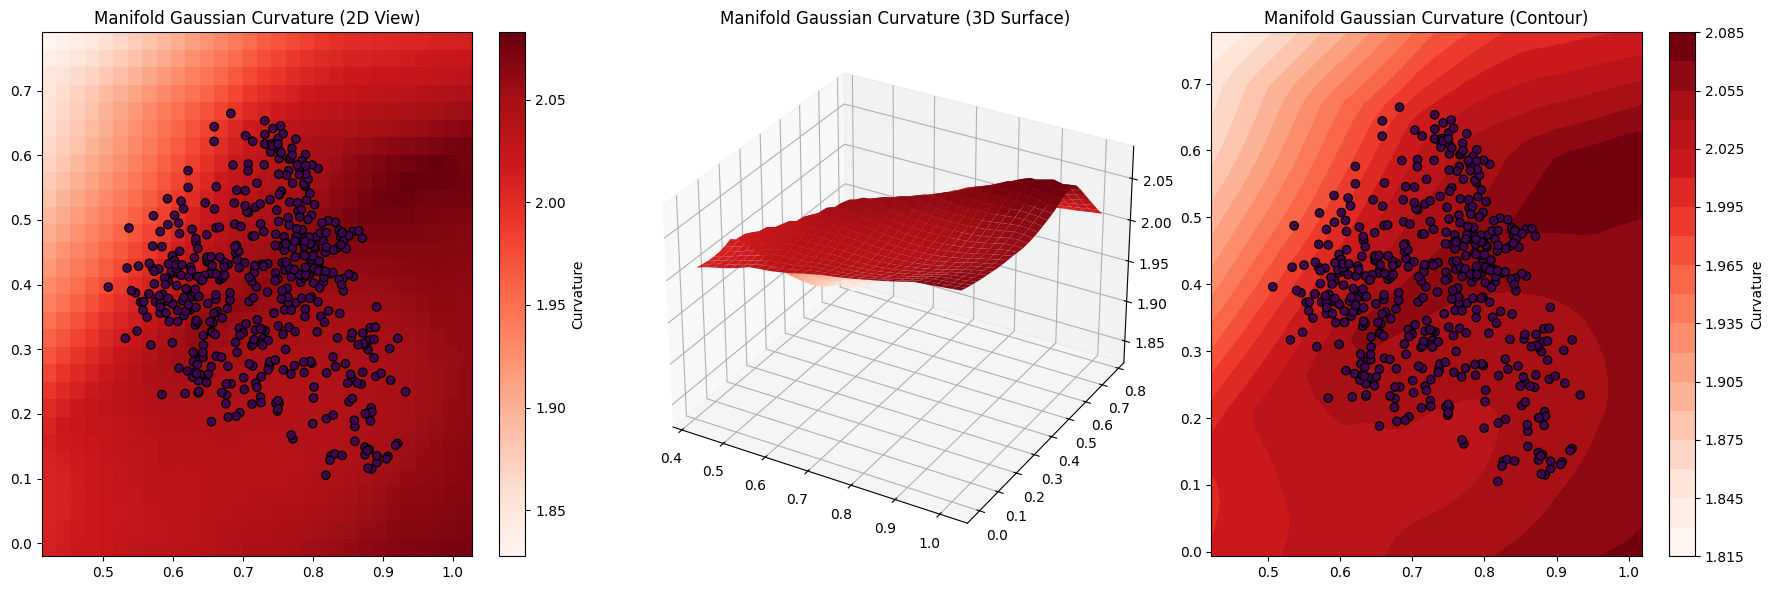

In [9]:
import copy
model_phase1 = model_phase1.to('cpu')
model_phase2 = copy.deepcopy(model_phase1)

model_phase1.eval()

with torch.no_grad():
    x = single_graph.x.to(device)
    edge_index = single_graph.edge_index.to(device)
    latent_mu = model_phase1.encode(x, edge_index=edge_index)

latent_points = latent_mu[0]

model_phase1.set_compute_latent_manifold(True)
model_phase1.construct_latent_manifold(bounds=BoundedManifold.hypercube_bounds(latent_points, margin=0.2, relative=True), force=True)
model_phase1.get_latent_manifold().compute_full_grid_metric_tensor()
model_phase1.get_latent_manifold().visualize_manifold_curvature(data_points=latent_points)


In [10]:
from framework.torchVersions.distanceApproximations import DistanceApproximations

import weakref

class LatentDistanceDecoder(DecoderBase):
    """
    Fictive decoder that outputs latent codes but computes a meaningful loss 
    based on pairwise distances between connected nodes using Jacobian-based metrics.
    Enhanced with simple but effective caching.
    """
    def __init__(
        self, 
        latent_dim: int,
        distance_mode: str = "linear_interpolation",  # or "direct"
        num_integration_points: int = 10,
        metric_regularization: float = 1e-6,
        name: str = "latent_distance_decoder"
    ):
        super(LatentDistanceDecoder, self).__init__(latent_dim, name)
        
        self.distance_mode = distance_mode
        self.num_integration_points = num_integration_points
        self.metric_regularization = metric_regularization
        self.model = None  # Weak reference to the model instance

    def giveVAEInstance(self, model: VAE):
        self.model = weakref.ref(model)

    def forward(self, z: torch.Tensor, **kwargs) -> Dict[str, torch.Tensor]:
        """Forward pass - simply returns the latent codes (fictive decoder)"""
        return {"latent_codes": z.clone()}
        
    def _riemannian_distance(self, z1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
        #print(f"[riemannian_distance] Computing pairwise distances for batch size {z.shape[0]}")
        #start_time = time.time()
        if self.model is None or self.model() is None:
            raise ValueError("Model instance not set. Call giveVAEInstance(model) first.")
        model = self.model()

        distances = []
        if z1.ndim == 1:
            z1 = z1.unsqueeze(0)
        if z2.ndim == 1:
            z2 = z2.unsqueeze(0)
        for i, (u_vec, v_vec) in enumerate(zip(z1, z2)):
            if self.distance_mode == "linear_interpolation":
                d = DistanceApproximations.linear_interpolation_distance(model.get_latent_manifold(), u_vec, v_vec, 
                                                                         num_points=self.num_integration_points)
            else:
                d = model.get_latent_manifold().exact_geodesic_distance(u_vec, v_vec)
            #print(f"  [distance] Sample {i}: {d.item():.4f}")
            distances.append(d)
        #print(f"[riemannian_distance] Done in {time.time() - start_time:.4f}s")
        return torch.stack(distances)
    
    def compute_loss(
        self,
        outputs: Dict[str, torch.Tensor],
        targets: Dict[str, torch.Tensor],
        negative_distance_weight: float = 1,
    ) -> torch.Tensor:
        """
        Compute loss based on:
        - Pairwise distances between connected nodes (positive edges)
        - Penalty for non-connected nodes being too close in the latent space (negative edges)
        """
        if self.model is None or self.model() is None:
            raise ValueError("Model instance not set. Call giveVAEInstance(model) first.")
        self.model().get_latent_manifold().compute_full_grid_metric_tensor()

        z = outputs["latent_codes"]
        
        total_pos_distance = 0.0
        total_neg_penalty = 0.0
        num_pos_edges = 0

        edge_set = set()  # To avoid sampling existing edges as negatives

        if "edge_index" in targets:
            edge_index = targets["edge_index"]
            num_negative_samples = edge_index.size(1)
            edge_labels = targets.get("edge_labels", None)
            src_nodes, dst_nodes = edge_index[0], edge_index[1]
            
            for idx in tqdm(range(edge_index.size(1)), desc="Positive Edges"):
                src_idx = src_nodes[idx].item()
                dst_idx = dst_nodes[idx].item()
                
                if src_idx == dst_idx:
                    continue

                edge_set.add((src_idx, dst_idx))
                edge_set.add((dst_idx, src_idx))  # Undirected
                
                if edge_labels is not None:
                    edge_weight = edge_labels[idx].item()
                    if edge_weight <= 0:
                        continue
                else:
                    edge_weight = 1.0

                distance = self._riemannian_distance(z[src_idx], z[dst_idx])
                total_pos_distance += edge_weight * distance
                num_pos_edges += edge_weight

            # Sample negative edges (no connection in edge_index)
            num_nodes = z.size(0)
            neg_samples = 0
            with tqdm(total=num_negative_samples, desc="Negative Sampling") as pbar:
                while neg_samples < num_negative_samples:
                    i = torch.randint(0, num_nodes, (1,)).item()
                    j = torch.randint(0, num_nodes, (1,)).item()
                    if i == j or (i, j) in edge_set:
                        continue
                    distance = self._riemannian_distance(z[i], z[j])
                    penalty = 1.0 / (1.0 + (distance)**2)
                    total_neg_penalty += penalty
                    neg_samples += 1
                    pbar.update(1)

        elif "adj_matrix" in targets:
            adj_matrix = targets["adj_matrix"]
            num_negative_samples = int((adj_matrix != 0).sum().item() / 2)
            num_nodes = adj_matrix.size(0)

            for i in tqdm(range(num_nodes), desc="Positive Adjacency"):
                for j in range(i + 1, num_nodes):
                    edge_weight = adj_matrix[i, j].item()
                    if edge_weight > 0:
                        edge_set.add((i, j))
                        edge_set.add((j, i))
                        distance = self._riemannian_distance(z[i], z[j])
                        total_pos_distance += edge_weight * (distance**2)
                        num_pos_edges += edge_weight

            # Sample negative edges
            neg_samples = 0
            with tqdm(total=num_negative_samples, desc="Negative Sampling") as pbar:
                while neg_samples < num_negative_samples:
                    i = torch.randint(0, num_nodes, (1,)).item()
                    j = torch.randint(0, num_nodes, (1,)).item()
                    if i == j or (i, j) in edge_set:
                        continue
                    distance = self._riemannian_distance(z[i], z[j])
                    penalty = 1.0 / (1.0 + distance)
                    total_neg_penalty += penalty
                    neg_samples += 1
                    pbar.update(1)

        else:
            raise ValueError("Targets must contain either 'edge_index' or 'adj_matrix'")
        
        gc.collect()

        # Compute final loss
        if num_pos_edges > 0:
            avg_pos_distance = total_pos_distance / num_pos_edges
            pos_loss = avg_pos_distance
        else:
            pos_loss = torch.tensor(0.0, device=z.device, requires_grad=True)

        neg_loss = negative_distance_weight * (total_neg_penalty / num_negative_samples) #* ((2 * num_negative_samples) / (num_nodes*(num_nodes-1)))
        print("Loss: pos=", pos_loss.sum(), " neg=", neg_loss.sum(), " (", (neg_loss.sum()*100)/(pos_loss.sum() + neg_loss.sum()) , "%) total=", pos_loss.sum() + neg_loss.sum())

        #return pos_loss * (neg_loss.detach() / (pos_loss.detach() + 1e-8)) + neg_loss
        return pos_loss + neg_loss


In [11]:
lr_phase2 = 0.001

print("=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===")

model_phase2.set_compute_latent_manifold(True)
model_phase2.construct_latent_manifold(bounds=BoundedManifold.hypercube_bounds(latent_points, margin=0.2, relative=True), force=True)
#model_phase2.get_latent_manifold().compute_full_grid_metric_tensor()

distance_decoder = LatentDistanceDecoder(
   latent_dim=latent_dim,
   distance_mode="linear_interpolation",  # or "direct"
   name="adj_decoder",
   num_integration_points=10
)

# distance_decoder = ManifoldHeatKernelDecoder(
#     latent_dim=latent_dim,
#     heat_time=torch.logspace(start=-1, end=2, steps=10).tolist(),  # Adjust for local vs global structure
#     num_eigenvalues=150,
#     heat_kernel_approximation="spectral",
#     num_integration_points=10,
#     reference_decoder_name="node_attr_decoder",
#     name="adj_decoder",
# )


# distance_decoder = LatentDistanceDecoder(
#     latent_dim=latent_dim,
#     reference_decoder=node_decoder,
#     grid_size=32, z_min=-2.0, z_max=2.0, 
#     metric_regularization=1e-5)

# Add to your GraphVAE model
model_phase2.add_decoder(distance_decoder)

# Set reference decoder (the node attribute decoder)
#model_phase2.get_decoder("adj_decoder").giveManifoldInstance(model_phase2.get_latent_manifold())
model_phase2.get_decoder("adj_decoder").giveVAEInstance(model_phase2)

# Reset KL scheduler for phase 2
model_phase2.kl_scheduler = KLAnnealingScheduler(
    anneal_start=0,  
    anneal_end=0,
    anneal_steps=phase2_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Phase 2 training
history_phase2 = train_phase2(
    model=model_phase2,
    data_loader=single_graph_list,
    num_epochs=phase2_epochs,
    lr=lr_phase2,
    weight_decay=1e-5,
    decoder_weights={"adj_decoder": 1, "node_attr_decoder":1 },
    verbose=False,
    device=device,
)

print("\n=== Phase 2 Complete ===")
visualize_training(history_phase2)
#visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase2, single_graph, sample_features=dimP)
#visualize_latent_space(model_phase1, [single_graph])
#plot_curvature(model_phase1, single_graph)


# Combine histories
combined_history = {
    "phase1": history_phase1,
    "phase2": history_phase2
}

# Unfreeze encoder for potential further use
model_phase1.set_encoder_freeze(False)

=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===


Computing metric tensors: 100%|██████████| 10000/10000 [00:05<00:00, 1962.17it/s]


Forward pass: compute_latent_manifold = True self.training = True


Negative Sampling: 100%|██████████| 23654/23654 [00:32<00:00, 716.85it/s]


Loss: pos= tensor(1.6435, grad_fn=<SumBackward0>)  neg= tensor(0.3616, grad_fn=<SumBackward0>)  ( tensor(18.0326, grad_fn=<DivBackward0>) %) total= tensor(2.0050, grad_fn=<AddBackward0>)
Forward pass: compute_latent_manifold = True self.training = True


Positive Edges:  26%|██▌       | 6159/23654 [00:20<00:57, 302.71it/s]


KeyboardInterrupt: 